In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
sft_model_path = "/content/drive/MyDrive/rlhf_models/sft_model"
reward_model_path = "/content/drive/MyDrive/rlhf_models/reward_model.pt"


In [3]:
import torch
from typing import Optional
from torch import nn
import numpy as np
from transformers import AutoModelForCausalLM

class RewardHead(nn.Module):
    """
    The RewardHead class implements a head for GPT2
    that returns a scalar for each output token.
    """

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.reward = nn.Linear(self.hidden_size, 1)
        self._post_init()

    def _post_init(self):
        nn.init.normal_(self.reward.weight, std=(1.0 / np.sqrt(self.hidden_size + 1)))
        nn.init.zeros_(self.reward.bias)

    def forward(self, hidden_states):
        output = hidden_states
        return self.reward(output)


class GPT2RewardModel(nn.Module):
    """
    GPT2 model with a reward head on top.
    """

    def __init__(self, model_name):
        super().__init__()
        self.llm = AutoModelForCausalLM.from_pretrained(model_name)
        self.reward_head = RewardHead(self.llm.config)

    def forward(
        self,
        input_ids,
        attention_mask,
    ) -> Optional[torch.FloatTensor]:

        transformer_outputs = self.llm.forward(
            input_ids,
            attention_mask=attention_mask,
            output_hidden_states = True,
        )

        # Get the last hidden state
        last_hidden_state = transformer_outputs.hidden_states[-1]

        # Apply the reward head
        rewards = self.reward_head(last_hidden_state).squeeze(-1)

        return torch.sigmoid(rewards)

In [5]:
model_name = "gpt2"
reward_model = GPT2RewardModel(model_name)
reward_model.load_state_dict(torch.load(reward_model_path, map_location='cpu'))

<All keys matched successfully>

In [10]:
reward_model

GPT2RewardModel(
  (llm): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D(nf=2304, nx=768)
            (c_proj): Conv1D(nf=768, nx=768)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D(nf=3072, nx=768)
            (c_proj): Conv1D(nf=768, nx=3072)
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=768, out_feature

Model with value head

In [7]:
import torch
from typing import Optional
from torch import nn
import numpy as np
from transformers import AutoModelForCausalLM

class ValueHead(nn.Module):
    """
    The ValueHead class implements a head for GPT2
    that returns a scalar for each output token.
    """

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.value = nn.Linear(self.hidden_size, 1)
        self._post_init()

    def _post_init(self):
        nn.init.normal_(self.value.weight, std=(1.0 / np.sqrt(self.hidden_size + 1)))
        nn.init.zeros_(self.value.bias)

    def forward(self, hidden_states):
        output = hidden_states
        return self.value(output)


class ModelForCausalLMWithValueHead(nn.Module):
    """
    GPT2 model with a value head on top.
    """

    def __init__(self, model_path):
        super().__init__()
        self.llm = AutoModelForCausalLM.from_pretrained(model_path)
        self.v_head = ValueHead(self.llm.config)

    def forward(
        self,
        input_ids,
        attention_mask,
    ) -> Optional[torch.FloatTensor]:

        transformer_outputs = self.llm.forward(
            input_ids,
            attention_mask=attention_mask,
            output_hidden_states = True,
        )
        lm_logits = transformer_outputs.logits
        # Get the last hidden state
        last_hidden_state = transformer_outputs.hidden_states[-1]

        # Apply the reward head
        value = self.v_head(last_hidden_state).squeeze(-1)
        return lm_logits, value

    def generate(self, *args, **kwargs):
        return self.llm.generate(*args, **kwargs)

In [8]:
model = ModelForCausalLMWithValueHead(sft_model_path)

In [9]:
model

ModelForCausalLMWithValueHead(
  (llm): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D(nf=2304, nx=768)
            (c_proj): Conv1D(nf=768, nx=768)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D(nf=3072, nx=768)
            (c_proj): Conv1D(nf=768, nx=3072)
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=76

In [11]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
%pip install datasets==3.5.0

In [13]:
from datasets import load_dataset
dataset = load_dataset("sst2")
dataset

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})

In [14]:
ds_train, ds_val = dataset['train'], dataset['validation']

In [15]:
len(ds_train)

67349

In [16]:
len(ds_val)

872

In [17]:
ds_train = ds_train.filter(lambda x: len(x['sentence'].split(' ')) > 8)

Filter:   0%|          | 0/67349 [00:00<?, ? examples/s]

In [22]:
len(ds_train), ds_train

(31105,
 Dataset({
     features: ['idx', 'sentence', 'label'],
     num_rows: 31105
 }))

In [19]:
ds_val = ds_val.filter(lambda x: len(x['sentence'].split(' ')) > 8)

Filter:   0%|          | 0/872 [00:00<?, ? examples/s]

In [21]:
len(ds_val), ds_val

(807,
 Dataset({
     features: ['idx', 'sentence', 'label'],
     num_rows: 807
 }))

In [23]:
import random
input_min_token_length = 2
input_max_token_length = 8
input_token_length_range = list(range(input_min_token_length, input_max_token_length))
print(input_token_length_range)


[2, 3, 4, 5, 6, 7]


In [24]:
random.choice(input_token_length_range)

4

In [25]:
def tokenize(sample):
    input_size = random.choice(input_token_length_range)
    sample['input_ids'] = tokenizer.encode(sample['sentence'])[:input_size]
    sample['attention_mask'] = [1] * len(sample['input_ids'])
    sample['query'] = tokenizer.decode(sample['input_ids'])
    return sample

map_kwargs = {
    "batched": False,
    "remove_columns": ['idx', 'sentence', 'label']
}

tokenized_dataset_train = ds_train.map(tokenize, **map_kwargs)
tokenized_dataset_val = ds_val.map(tokenize, **map_kwargs)

Map:   0%|          | 0/31105 [00:00<?, ? examples/s]

Map:   0%|          | 0/807 [00:00<?, ? examples/s]

In [26]:
tokenized_dataset_train.set_format(type='torch')
tokenized_dataset_val.set_format(type='torch')

In [28]:
tokenized_dataset_train[6]

{'input_ids': tensor([1640,  883]),
 'attention_mask': tensor([1, 1]),
 'query': 'for those'}

In [29]:
REWARD_TOKEN_ID = tokenizer.eos_token_id

In [30]:
from torch.utils.data import DataLoader

batch_size = 32

def collator(batch):
    return dict((key, [d[key] for d in batch]) for key in batch[0])

train_dataloader = DataLoader(tokenized_dataset_train, batch_size=batch_size, collate_fn=collator, shuffle=True)
val_dataloader = DataLoader(tokenized_dataset_val, batch_size=batch_size, collate_fn=collator, shuffle=True)

In [31]:

batch = next(iter(train_dataloader))
batch

{'input_ids': [tensor([   75,  1530,   290, 21104]),
  tensor([  292,   281,  9739, 10965,   329,   262,  2276]),
  tensor([5661,  649,  474, 9248,  286, 7838]),
  tensor([  292,   257, 19201]),
  tensor([49123,   340]),
  tensor([ 1462, 17864,   262]),
  tensor([  338,   257, 29210,   284]),
  tensor([  271,   257,  1339,   286,  1165,   867, 36236]),
  tensor([ 271, 1107, 5699,  284, 8483,  621,  257]),
  tensor([ 1477,    88,   321, 25786]),
  tensor([29642,   422, 46078]),
  tensor([ 1169, 45550,  8033,   286, 12886]),
  tensor([ 1053,   587,  3621,   611,   262,  3159, 34422]),
  tensor([  85,  499,  312, 8674,  705]),
  tensor([ 271,  339,  468,  645, 2095,  837, 1842]),
  tensor([   64, 15499,   837,   257,  2646]),
  tensor([25833,   306, 23007]),
  tensor([270, 458]),
  tensor([ 9535, 37840,   357,  2592,   262, 14346]),
  tensor([10594,   407,   467,   866,   287,   262]),
  tensor([568, 881, 326, 530]),
  tensor([ 1169, 44207]),
  tensor([35194,  2251,   257,  3716,   837]),

In [32]:
output_min_length = 5
output_max_length = 16

generation_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.pad_token_id
}

sample generation


In [33]:
new_tokens = random.choice(list(range(output_min_length, output_max_length)))
generation_kwargs["max_new_tokens"] = new_tokens
sample = tokenizer('Hi, this')
sample

{'input_ids': [17250, 11, 428], 'attention_mask': [1, 1, 1]}

In [34]:
query_response = model.generate(
    input_ids=torch.tensor(sample['input_ids']).unsqueeze(0),
    attention_mask=torch.tensor(sample['attention_mask']).unsqueeze(0),
    **generation_kwargs
    ).squeeze(0)
query_response

tensor([17250,    11,   428, 33544, 28695,  2646,   837,  7924,   416,  5928,
           12, 16129,  3491,   474,   320,  7586,   837,   220])

In [35]:
tokenizer.decode(query_response)

'Hi, this mildly provocative film , directed by domestic-language star jim brown , '

In [36]:
with torch.no_grad():
    query_response_score = torch.cat([query_response, torch.tensor([REWARD_TOKEN_ID])])
    attention_mask = torch.ones_like(query_response_score, dtype=torch.long)
    score = reward_model(query_response_score.unsqueeze(0), attention_mask.unsqueeze(0)).squeeze(0)[-1]
score

tensor(0.9810)

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
reward_model = reward_model.to(device)

query_tensors = batch['input_ids']
query_attention_masks = batch['attention_mask']

response_tensors = []
query_response_tensors = []
score_tensors = []

for i, query in enumerate(query_tensors):
    query = query.to(device)
    query_attention_mask = query_attention_masks[i].to(device)
    new_tokens = random.choice(list(range(output_min_length, output_max_length)))
    generation_kwargs["max_new_tokens"] = new_tokens
    query_response = model.generate(
        input_ids=query.unsqueeze(0),
        attention_mask=query_attention_mask.unsqueeze(0),
        **generation_kwargs
    ).squeeze(0)

    response_len = len(query_response) - len(query)
    response_tensors.append(query_response[-response_len:])
    query_response_tensors.append(query_response)

    with torch.no_grad():
        query_response_score = torch.cat([query_response, torch.tensor([REWARD_TOKEN_ID]).to(device)])
        attention_mask = torch.ones_like(query_response_score, dtype=torch.long)
        score = reward_model(query_response_score.unsqueeze(0), attention_mask.unsqueeze(0)).squeeze(0)[-1]
        score = 2 * (score - 0.5)
    score_tensors.append(score)

batch["response"] = [tokenizer.decode(response) for response in response_tensors]
print(batch['response'])

[' photographed  vernacular illustrating vernacular', ' public , but as a documentary resource for people', " carries with it a quality that is rich with the medium 's playful and", ' ( surprisingly ) dramatic event iced by appropriate chemistry', ' a must for coffee rich kids out there right now  ', ' belly buttons !" makes the facetiously nutty romantic', ' ingenuity that the film ... holds onto hope even as it', ' and too many bowel movements iced over by a previousiche . ', ' movie       ike    ', " 's frustrating presence in the film", ' jackson , who on the other hand is remarkably charming , we are', ' criticism iced a guilty pleasure icing their', ' and producers of this magnificent documentary', 's tribute to chris gyllenhaal receives anti-establishment root', ' story or development , delightfully deadpan that might', ' whose core conceit is clear ian systema never drifts deep into', ' the need for a family presence \xa0around  ichthy , especially', 'umbs the ego , moving to o

Compute Reward

In [38]:
from copy import deepcopy
sft_model = deepcopy(model)

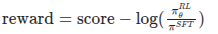

In [40]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [41]:
input_data = data_collator([
    {'input_ids': ids,
     'attention_mask': torch.ones_like(ids)} for ids in query_response_tensors
]).to(device)
input_data

{'input_ids': tensor([[   75,  1530,   290, 21104, 25880,   220,   220,   933, 12754,   220,
           359,   436,  8821,   220,   933, 12754, 50256, 50256, 50256, 50256,
         50256],
        [  292,   281,  9739, 10965,   329,   262,  2276,  1171,   837,   475,
           355,   257, 11648,  8271,   329,   661, 50256, 50256, 50256, 50256,
         50256],
        [ 5661,   649,   474,  9248,   286,  7838, 10732,   351,   340,   257,
          3081,   326,   318,  5527,   351,   262,  7090,   705,    82, 34264,
           290],
        [  292,   257, 19201,   357, 12362,  1267, 10092,  1785,   220,  3711,
           416,  5035, 16585, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256],
        [49123,   340,   257,  1276,   329,  6891,  5527,  3988,   503,   612,
           826,   783,   220,   220, 50256, 50256, 50256, 50256, 50256, 50256,
         50256],
        [ 1462, 17864,   262, 19921, 12163,   220,  2474,  1838,   262, 39144,
          6819,  6701,   774, 14

In [42]:
def compute_rewards(input_data, query_tensors, response_tensors, score_tensors):
    with torch.no_grad():
        logits, values = model(**input_data) # b, seq, vocab
        ref_logits, _ = sft_model(**input_data)
        logp = torch.nn.functional.log_softmax(logits[:, :-1, :], dim=-1)
        ref_logp = torch.nn.functional.log_softmax(ref_logits[:, :-1, :], dim=-1)

        labels = input_data['input_ids'][:, 1:] # b, seq

        logp = torch.gather(logp, 2, labels.unsqueeze(-1)).squeeze(-1) # batch, seq
        ref_logp = torch.gather(ref_logp, 2, labels.unsqueeze(-1)).squeeze(-1) # batch, seq

        kl = logp - ref_logp
        beta = 0.2
        rewards = - beta * kl
        attention_mask = input_data['attention_mask']
        masks = torch.zeros_like(attention_mask[:, 1:])
        masks[:,:] = attention_mask[:, 1:]
        for j in range(len(query_tensors)):
            start = len(query_tensors[j]) - 1
            end = start + len(response_tensors[j])
            masks[j, :start] = 0
            masks[j, end:] = 0
            rewards[j, end - 1] += score_tensors[j]
            rewards[j, :] *= masks[j, :]
            values[j, :-1] *= masks[j, :]

    return logp, rewards, values[:, :-1], masks

In [43]:
logprobs, rewards, values, masks = compute_rewards(input_data, query_tensors, response_tensors, score_tensors)
print(rewards[0])
print(input_data['input_ids'][0])
print(input_data['attention_mask'][0])

tensor([-0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, 0.9952, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000], device='cuda:0')
tensor([   75,  1530,   290, 21104, 25880,   220,   220,   933, 12754,   220,
          359,   436,  8821,   220,   933, 12754, 50256, 50256, 50256, 50256,
        50256], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       device='cuda:0')


In [44]:
print(masks[0])
print(values[0])

tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       device='cuda:0')
tensor([0.0000, 0.0000, 0.0000, 4.9626, 6.6975, 3.0778, 4.2859, 2.6505, 4.7866,
        2.5234, 0.2277, 3.5608, 7.8526, 1.3618, 1.9599, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000], device='cuda:0')


In [47]:
## compute advantage

In [45]:
def masked_mean(values, mask):
    return (values * mask).sum() / mask.sum()

def masked_var(values, mask):
    mean = masked_mean(values, mask)
    centred_values = values - mean
    return masked_mean(centred_values ** 2, mask)

def masked_whiten(values, mask):
    mean, var = masked_mean(values, mask), masked_var(values, mask)
    whitened = (values - mean) * torch.rsqrt(var + 1e-8)
    whitened += mean
    return whitened

def compute_advantage(rewards, values, masks):
    lastgae = 0.0
    advantage_reversed = []
    seq_length = rewards.shape[-1]
    gamma, lam = 1.0, 0.95

    for t in reversed(range(seq_length)):
        nextvalues = values[:, t + 1] if t < seq_length - 1 else 0.0
        delta = rewards[:, t] + gamma * nextvalues - values[:, t]
        lastgae = delta + gamma * lam * lastgae
        advantage_reversed.append(lastgae)
    advantages = torch.stack(advantage_reversed[::-1], dim=1)
    advantages = masked_whiten(advantages, masks)

    returns = advantages + values
    return advantages, returns

In [46]:
advantages, returns = compute_advantage(rewards, values, masks)
print(advantages[0])
print(returns[0])

tensor([-1.6533, -1.6128, -1.5702, -3.4768, -4.2145, -2.8854, -3.3848, -2.7923,
        -3.6518, -2.8264, -1.9449, -3.2305, -4.9607, -2.5418, -2.7833, -2.4229,
        -2.4229, -2.4229, -2.4229, -2.4229], device='cuda:0')
tensor([-1.6533, -1.6128, -1.5702,  1.4858,  2.4830,  0.1924,  0.9011, -0.1418,
         1.1349, -0.3031, -1.7172,  0.3303,  2.8919, -1.1800, -0.8234, -2.4229,
        -2.4229, -2.4229, -2.4229, -2.4229], device='cuda:0')


PPO training (mini-batch)

In [48]:
learning_rate = 1e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [49]:
np.random.permutation(batch_size)

array([ 6, 23,  7, 16, 26,  9,  8, 28, 31,  2, 25,  5, 12,  4, 24, 27, 14,
       11, 17,  0, 21, 15, 10, 30, 20, 18,  1, 13, 19, 22, 29,  3])

In [50]:
mini_batch_size = 4
ppo_epochs = 4

cliprange_ratio = 0.2

v_loss_coeff = 0.1

ratio_threshold = 10

def compute_loss(old_logprobs, values, logprobs, vpreds, masks, advantages, returns):
    ratio = torch.exp(logprobs - old_logprobs)
    pg_loss1 = - ratio * advantages
    pg_loss2 = - torch.clamp(ratio, 1 - cliprange_ratio, 1 + cliprange_ratio) * advantages
    pg_loss = masked_mean(torch.max(pg_loss1, pg_loss2), masks)

    v_loss = masked_mean((vpreds - returns) ** 2, masks)
    loss = pg_loss + v_loss_coeff * v_loss

    avg_ratio = masked_mean(ratio, masks)
    if avg_ratio > ratio_threshold:
        pg_loss = pg_loss * 0.0
        v_loss = v_loss * 0.0
        loss = loss * 0.0

    return loss, v_loss

def mini_batch_train():
    for ep in range(ppo_epochs):
        batch_inds = np.random.permutation(batch_size)

        for start in range(0, batch_size, mini_batch_size):
            end = start + mini_batch_size
            mini_batch_inds = batch_inds[start:end]

            mb_model_inputs = {
                'input_ids': input_data['input_ids'][mini_batch_inds],
                'attention_mask': input_data['attention_mask'][mini_batch_inds]
            }
            mb_logits, mb_vpreds = model(**mb_model_inputs)
            mb_logits = torch.nn.functional.log_softmax(mb_logits[:, :-1, :], dim=-1)
            mb_logprobs = torch.gather(mb_logits, 2, mb_model_inputs['input_ids'][:, 1:].unsqueeze(-1)).squeeze(-1)

            loss, loss_v = compute_loss(
                logprobs[mini_batch_inds],
                values[mini_batch_inds],
                mb_logprobs,
                mb_vpreds[:, :-1],
                masks[mini_batch_inds],
                advantages[mini_batch_inds],
                returns[mini_batch_inds]
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print('loss/total', loss.item())
    print('mini-batch training finished')


In [51]:
mini_batch_train()

loss/total 5.2314043045043945
loss/total 5.401344299316406
loss/total 5.679960250854492
loss/total 5.3306565284729
loss/total 5.832033157348633
loss/total 5.384555339813232
loss/total 4.427805423736572
loss/total 4.387842655181885
loss/total 4.241067409515381
loss/total 4.301272869110107
loss/total 4.700424671173096
loss/total 3.8573009967803955
loss/total 3.7885594367980957
loss/total 4.175734519958496
loss/total 3.991818428039551
loss/total 3.4170572757720947
loss/total 3.552513360977173
loss/total 3.7322936058044434
loss/total 3.879672050476074
loss/total 3.5074164867401123
loss/total 3.422112464904785
loss/total 3.429016590118408
loss/total 3.432335376739502
loss/total 3.66152286529541
loss/total 3.308905839920044
loss/total 3.317748546600342
loss/total 3.5992794036865234
loss/total 3.4217231273651123
loss/total 3.757737636566162
loss/total 3.269853115081787
loss/total 3.0028910636901855
loss/total 3.40781831741333
mini-batch training finished


In [52]:
num_epochs = 1

for epoch in range(num_epochs):
    for batch in train_dataloader:
        # Generate responses
        query_tensors = batch['input_ids']
        query_attention_masks = batch['attention_mask']

        response_tensors = []
        query_response_tensors = []
        score_tensors = []

        for i, query in enumerate(query_tensors):
            query = query.to(device)
            query_attention_mask = query_attention_masks[i].to(device)
            new_tokens = random.choice(list(range(output_min_length, output_max_length)))
            generation_kwargs["max_new_tokens"] = new_tokens
            query_response = model.generate(
                input_ids=query.unsqueeze(0),
                attention_mask=query_attention_mask.unsqueeze(0),
                **generation_kwargs
                ).squeeze(0)

            response_len = len(query_response) - len(query)
            response_tensors.append(query_response[-response_len:])
            query_response_tensors.append(query_response)

            with torch.no_grad():
                query_response_score = torch.cat([query_response, torch.tensor([REWARD_TOKEN_ID]).to(device)])
                attention_mask = torch.ones_like(query_response_score, dtype=torch.long)
                score = reward_model(query_response_score.unsqueeze(0), attention_mask.unsqueeze(0)).squeeze(0)[-1]
                score = 2 * (score - 0.5)
            score_tensors.append(score)

        input_data = data_collator([
            {
                'input_ids': ids,
                'attention_mask': torch.ones_like(ids)
            }
            for ids in query_response_tensors
        ]).to(device)

        # rewards and advantages
        logprobs, rewards, values, masks = compute_rewards(input_data, query_tensors, response_tensors, score_tensors)
        advantages, returns = compute_advantage(rewards, values, masks)

        # mini batch training
        mini_batch_train()
    print(f'epoch {epoch + 1} finished')

loss/total 2.388521671295166
loss/total 2.9489901065826416
loss/total 2.4598329067230225
loss/total 2.2536380290985107
loss/total 2.5460336208343506
loss/total 2.7481255531311035
loss/total 2.417863130569458
loss/total 2.600614309310913
loss/total 1.8104966878890991
loss/total 2.2317097187042236
loss/total 1.956847071647644
loss/total 2.916503667831421
loss/total 2.3707427978515625
loss/total 2.0114495754241943
loss/total 1.8269332647323608
loss/total 1.8921663761138916
loss/total 1.8186665773391724
loss/total 2.23164439201355
loss/total 1.7091906070709229
loss/total 1.5973166227340698
loss/total 2.0715317726135254
loss/total 1.837418556213379
loss/total 1.8716117143630981
loss/total 2.1845760345458984
loss/total 2.0234854221343994
loss/total 1.753372073173523
loss/total 2.1355326175689697
loss/total 1.5149872303009033
loss/total 1.9567562341690063
loss/total 1.617017149925232
loss/total 1.7217332124710083
loss/total 2.0545759201049805
mini-batch training finished
loss/total 1.06637561

KeyboardInterrupt: 

In [53]:
len(tokenized_dataset_val)

807

In [54]:
val_gen_lengths = [0] * len(tokenized_dataset_val)
for i in range(len(tokenized_dataset_val)):
    val_gen_lengths[i] = random.choice(list(range(output_min_length, output_max_length)))

In [55]:
val_gen_lengths[:10]

[14, 10, 11, 8, 13, 7, 13, 9, 11, 14]

In [56]:
def validate():
    scores = []
    for b, batch in enumerate(val_dataloader):
        # Generate_responses
        query_tensors = batch['input_ids']
        query_attention_masks = batch['attention_mask']
        for i, query in enumerate(query_tensors):
            query = query.to(device)
            query_attention_mask = query_attention_masks[i].to(device)
            new_tokens = val_gen_lengths[b * len(query_tensors) + i]
            generation_kwargs["max_new_tokens"] = new_tokens
            query_response = model.generate(
                input_ids=query.unsqueeze(0),
                attention_mask=query_attention_mask.unsqueeze(0),
                **generation_kwargs
                ).squeeze(0)
            query_response_score = torch.cat([query_response, torch.tensor([REWARD_TOKEN_ID]).to(device)])
            attention_mask = torch.ones_like(query_response_score, dtype=torch.long)
            score = reward_model(query_response_score.unsqueeze(0), attention_mask.unsqueeze(0)).squeeze(0)[-1]
            score = 2 * (score - 0.5)
            scores.append(score.item())
    print('avg score:', sum(scores) / len(scores))

In [57]:
validate()

avg score: 0.27958692575180544


In [58]:
torch.save(model.state_dict(), 'ppo_model_epoch_1.pt')

In [62]:
model_path = '/content/drive/MyDrive/rlhf_models/sft_model'
model = ModelForCausalLMWithValueHead(model_path).to(device)


In [63]:
validate()

avg score: -0.009417579593563907
